## 多头注意力

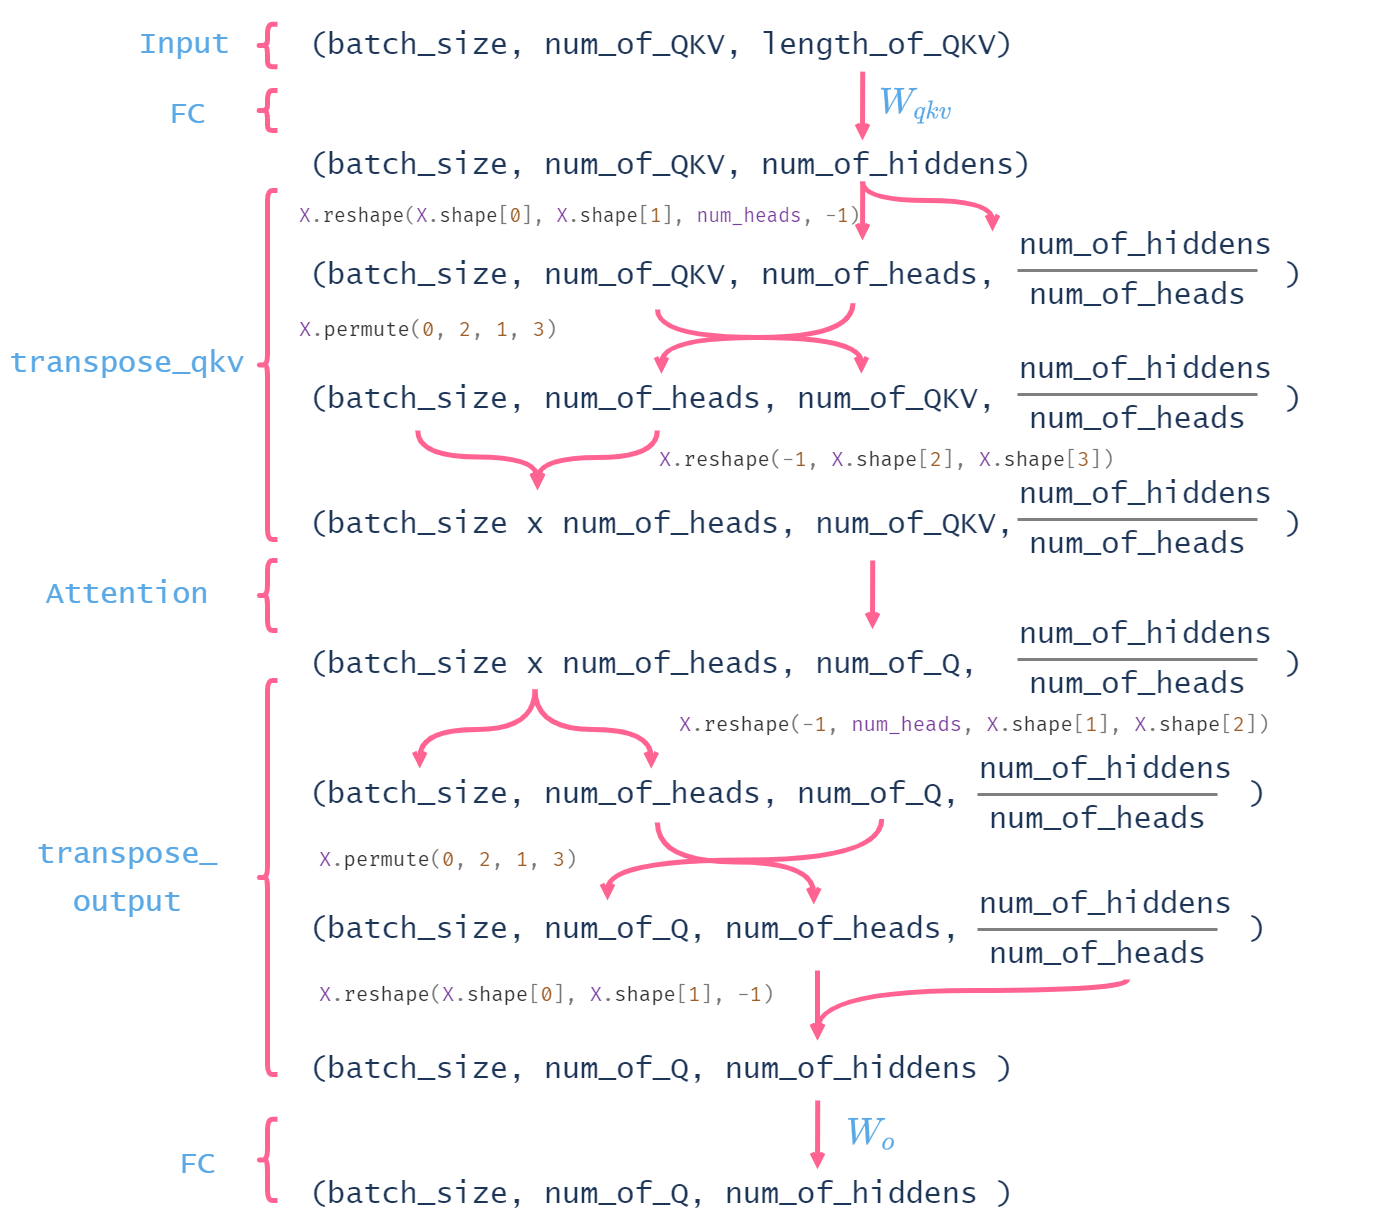

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def transpose_qkv(X, num_heads):
    # 将输入张量 X 转换为多头注意力的格式
    # X 的形状为 (batch_size, seq_len, num_hiddens)
    # 返回的形状为 (batch_size, seq_len, num_heads, num_hiddens // num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # 交换维度，使得 num_heads 成为最后一个维度
    X = X.permute(0, 2, 1, 3)

    # 将张量的形状转换为 (batch_size * num_heads, seq_len, num_hiddens // num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    # 将多头注意力的输出张量转换回原始形状
    # X 的形状为 (batch_size * num_heads, seq_len, num_hiddens // num_heads)
    # 返回的形状为 (batch_size, seq_len, num_hiddens)
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [4]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [5]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## Transformer

In [6]:
import math 
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### 基于位置的前馈网络

其实就是一个MLP

“位置”表示的是每个句子中的每个词

这个MLP会作用在句子中的所有词上，只要词（的特征）是一样的，MLP的输出就是一样的

In [7]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super().__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [8]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.2969,  0.0767, -0.0935,  0.1593,  0.2819, -0.5656, -1.0522, -0.0573],
        [ 0.2969,  0.0767, -0.0935,  0.1593,  0.2819, -0.5656, -1.0522, -0.0573],
        [ 0.2969,  0.0767, -0.0935,  0.1593,  0.2819, -0.5656, -1.0522, -0.0573]],
       grad_fn=<SelectBackward0>)

### 残差链接和layer norm

LayerNorm：对每个样本的所有特征做归一化，适合序列建模（比如 Transformer）

BatchNorm：对同一特征在整个 batch 里的值做归一化，适合图像等任务

In [9]:
ln = nn.LayerNorm(2) # 括号里是维度
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [10]:
ln = nn.LayerNorm(3)
bn = nn.BatchNorm1d(3)
X = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)


In [11]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [12]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.rand((2, 3, 4)))

tensor([[[ 1.3662,  1.2500, -0.2136, -0.2620],
         [-0.0630,  0.4530, -0.0844, -1.4193],
         [ 0.7895, -1.2390, -1.6851,  1.1076]],

        [[-0.0020,  0.2593,  1.6000,  1.7550],
         [-0.3652, -1.4966,  0.9384,  0.0380],
         [-1.1392, -0.4135,  0.0753, -1.2493]]],
       grad_fn=<NativeLayerNormBackward0>)

### Encoder

把上面实现的东西按顺序叠起来

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [14]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5) 
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [15]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, use_bias))
        
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X


**为什么 embedding 后要乘 math.sqrt(self.num_hiddens)？**

在 Transformer 的 embedding 层后面，通常会把嵌入向量乘以 `sqrt(num_hiddens)`，原因如下：

1. **防止数值太小**  
   embedding 层输出的向量，初始化时数值一般比较小。如果直接送进后面的网络，可能导致梯度消失或训练不稳定。

2. **和位置编码的数值范围匹配**  
   位置编码（PositionalEncoding）通常数值范围较大。如果不放大 embedding，位置编码的影响会太大，模型更关注位置信息而不是词本身。

3. **论文原始做法**  
   这是 Transformer 论文（Attention is All You Need）里的标准做法，目的是让 embedding 和位置编码在数值上“均衡”，提升训练效果。


In [16]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

### Decoder

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i  # 当前解码器层的编号，用于缓存自回归的key/value
        # 第一个多头自注意力层（解码器自注意力）
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # 残差连接+LayerNorm
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 第二个多头注意力层（编码器-解码器注意力）
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # 残差连接+LayerNorm
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 位置前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 残差连接+LayerNorm
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        # state[0]: 编码器输出，state[1]: 编码器有效长度，state[2]: 解码器缓存
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 处理自回归缓存（用于推理时逐步生成）
        if state[2][self.i] is None:
            key_values = X  # 第一次，没有缓存
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)  # 拼接历史
        state[2][self.i] = key_values  # 更新缓存

        # 训练时，构造自注意力的mask，保证每个位置只能看到前面的token
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None  # 推理时用缓存，不需要mask

        # 第一个多头自注意力（解码器自注意力）
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)  # 残差+归一化

        # 第二个多头注意力（编码器-解码器注意力）
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)  # 残差+归一化

        # 位置前馈网络
        out = self.addnorm3(Z, self.ffn(Z))  # 残差+归一化

        # 返回输出和新的state
        return out, state

In [18]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [19]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        self._attention_weights = [[None] * len(self.blks), [None] * len(self.blks)]
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state 
    
    @property
    def attention_weights(self):
        return self._attention_weights

### 训练

loss 0.031, 5002.3 tokens/sec on cuda:0


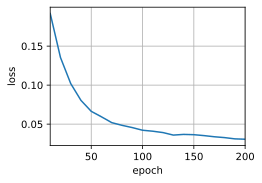

In [20]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [21]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je sais <unk> .,  bleu 0.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [22]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, 
                                                                             -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

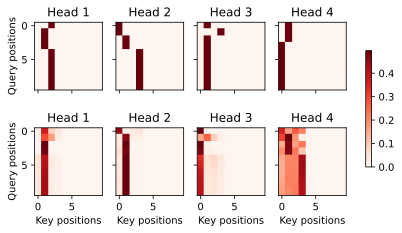

In [23]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [24]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

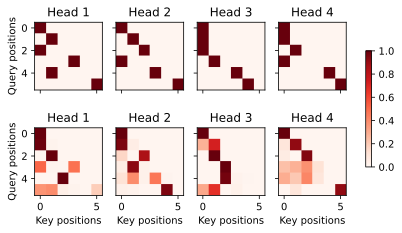

In [25]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

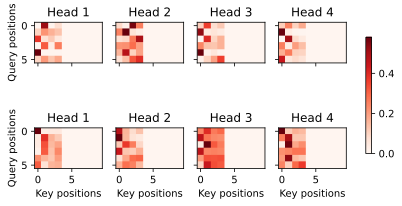

In [26]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))